**Общая информация**

**Срок сдачи:** 21 октября 2020, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [169]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_openml, fetch_20newsgroups

from sklearn.model_selection import train_test_split, KFold
from sklearn.neighbors import KNeighborsClassifier, KDTree
from sklearn.metrics import accuracy_score

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [150]:
from scipy.spatial.distance import minkowski # p = 2
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler

In [182]:
class MyKNeighborsClassifier(BaseEstimator):
    
    # 'mikowski' is equal scipy.spatial.distance.minkowski(p=2), but faster
    def __init__(self, n_neighbors, algorithm='brute', metric='minkowski', standardization=False):
        self.n = n_neighbors
        self.algorithm = algorithm
        self.metric = metric
        self.standardization = standardization
    
    def fit(self, X, y):
        if self.standardization:
            self.scaler = StandardScaler()
            self.X_train = self.scaler.fit_transform(X)
        else:
            self.X_train = X
        self.y_train = y
        if self.algorithm == 'kd_tree':
            self.tree = KDTree(X)
    
    def predict(self, X):
        if self.standardization:
            X=self.scaler.transform(X)
        
        if self.algorithm == 'brute':
            dist = pairwise_distances(X, X_train, metric=self.metric)
            ind = np.argpartition(dist, self.n)[:,:self.n]
            y_pred = np.apply_along_axis(lambda x: np.argmax(np.bincount(self.y_train[x])), 1, ind)
            
        elif self.algorithm == 'kd_tree':
            dist, ind = self.tree.query(X, self.n)
            y_pred = np.apply_along_axis(lambda x: np.argmax(np.bincount(self.y_train[x])), 1, ind)
        return y_pred
    
    @classmethod
    def get_best_k(cls, X, y, k_start=1, k_finish=10, step=1, metric='minkowski', m_splits=3):
        kf = KFold(n_splits=m_splits, shuffle=True)
        result = []
        for k in range(k_start, k_finish+1, step):
            k_acc = []
            for train_index, test_index in kf.split(vec_data):
                clf = cls(n_neighbors=k, algorithm='kd_tree', metric=metric)
                clf.fit(X[train_index], y[train_index])
                k_acc.append(accuracy_score(y[test_index], clf.predict(X[test_index])))
            result.append(np.array([k, np.mean(k_acc)]))
        result = np.array(result)
        return [int(result[np.argmax(result[:, 1])][0]), result]

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [105]:
iris = datasets.load_iris()

In [106]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [107]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [108]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [109]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)

assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [92]:
%time clf.fit(X_train, y_train)

CPU times: user 1.23 ms, sys: 5 µs, total: 1.23 ms
Wall time: 934 µs


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [97]:
%time my_clf.fit(X_train, y_train)

CPU times: user 17 µs, sys: 0 ns, total: 17 µs
Wall time: 24.8 µs
(135, 4) (135,)


In [94]:
%time clf.predict(X_test)

CPU times: user 5.17 ms, sys: 0 ns, total: 5.17 ms
Wall time: 3.84 ms


array([2, 2, 1, 2, 1, 0, 1, 0, 2, 0, 0, 1, 0, 1, 2])

In [41]:
%time my_clf.predict(X_test)

CPU times: user 3.68 ms, sys: 4.01 ms, total: 7.69 ms
Wall time: 4.8 ms


array([2, 2, 0, 0, 1, 2, 0, 0, 1, 1, 1, 0, 2, 2, 1])

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [42]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [43]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [44]:
%time clf.fit(X_train, y_train)

CPU times: user 4.42 ms, sys: 2 µs, total: 4.42 ms
Wall time: 3.85 ms


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [45]:
%time my_clf.fit(X_train, y_train)

CPU times: user 0 ns, sys: 1.76 ms, total: 1.76 ms
Wall time: 1.15 ms


In [46]:
%time clf.predict(X_test)

CPU times: user 3.24 ms, sys: 0 ns, total: 3.24 ms
Wall time: 2.27 ms


array([0, 1, 2, 0, 0, 2, 2, 1, 1, 1, 2, 0, 2, 0, 1])

In [47]:
%time my_clf.predict(X_test)

CPU times: user 2.56 ms, sys: 4.02 ms, total: 6.58 ms
Wall time: 4.07 ms


array([0, 1, 2, 0, 0, 2, 2, 1, 1, 1, 2, 0, 2, 0, 1])

In [48]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [53]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [54]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [186]:
vectorizer = CountVectorizer(max_df = 0.95, min_df=0.05)
vectorizer.fit_transform(data) 
vec_data = np.array([vectorizer.transform([text]).toarray() for text in data])
vec_data = vec_data.squeeze(1)

In [187]:
vec_data.shape

(11314, 236)

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [188]:
best_k_1, my_acc_1 = MyKNeighborsClassifier.get_best_k(vec_data, target, 1, 121, 5)
best_k_1

66

Text(0, 0.5, 'accuracy')

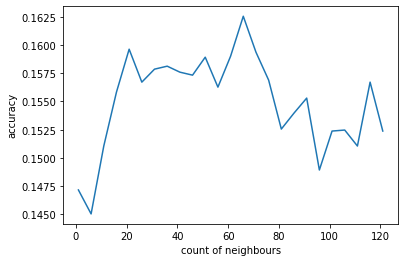

In [189]:
plt.plot(my_acc_1[:, 0], my_acc_1[:, 1])
plt.xlabel("count of neighbours")
plt.ylabel("accuracy")

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

In [226]:
tfidf_vectorizer = TfidfVectorizer(max_df = 0.95, min_df=0.05)
tfidf_vectorizer.fit_transform(data) 
tfidf_vec_data = np.array([tfidf_vectorizer.transform([text]).toarray() for text in data])
tfidf_vec_data = tfidf_vec_data.squeeze(1)

In [227]:
tfidf_vec_data.shape

(11314, 236)

In [195]:
best_k_2, my_acc_2 = MyKNeighborsClassifier.get_best_k(tfidf_vec_data, target, 1, 81, 3, metric='cosine') 
best_k_2

1

Text(0, 0.5, 'accuracy')

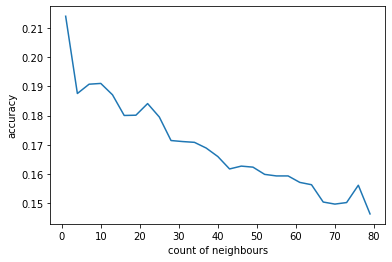

In [197]:
plt.plot(my_acc_2[:, 0], my_acc_2[:, 1])
plt.xlabel("count of neighbours")
plt.ylabel("accuracy")

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [222]:
newsgroups_test = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

In [223]:
data_test = newsgroups_test['data']
target_test = newsgroups_test['target']

In [224]:
test_vec_data = np.array([tfidf_vectorizer.transform([text]).toarray() for text in data_test])
test_vec_data = test_vec_data.squeeze(1)

In [225]:
test_vec_data.shape

(7532, 236)

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [228]:
my_best_clf = MyKNeighborsClassifier(n_neighbors=1, algorithm='kd_tree', metric='cosine')

In [229]:
my_best_clf.fit(tfidf_vec_data, target)

In [230]:
my_best_clf.predict(test_vec_data)

array([15, 12, 11, ..., 17, 12,  4])

In [231]:
target_test

array([ 7,  5,  0, ...,  9,  6, 15])

In [232]:
accuracy_score(target_test, my_best_clf.predict(test_vec_data))

0.16848114710568243

Точность стала меньше из-за того, что в тестовых данных наверняка встретились новые слова, наличие в тексте которых существенно влияет на отношение объекта к какому-либо классу, следовательно, мы теряем эту информацию. И наоборот, такие слова из train могут отсутсвовать в test, что также может приводить к ошибочной классификации. 